IMPORTS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf
from plotly.offline import plot, iplot, init_notebook_mode, download_plotlyjs
init_notebook_mode(connected=True)
cf.go_offline()

HOLT - WINTERS METHOD:

With Exponentially Weighted Moving Averages we applied smoothing by slowly decreasing the influence of older data using just one factor.

The Holt - Winters Method actually models 3 aspects of the time series being the average, trend and seasonality. In doing so it tries to predict the future provided the series is seasonal and repetitive over time.

For accurate results you must use good parameters. For seasonality it may seem that a day represents a season, but if a certain day of the week doesn't follow the pattern of the other days then a week may better represent your season.

FORECASTING:

Forecasting is the process of estimating future values based on what we know. If we have [1,3,5] we could propose that the forecast method would be 
\hat{y}_{x+1} = y_x + 2 expected values are denoted with \hat{y}.

USING MEAN TO FORECAST

In [3]:
# Let's say we have a more complex series 
# [52,60,64,53,59,55,64,58,55,52] # 53 is the real next value
# We might guess that a good estimate would be the average
s_1 = pd.Series([52,60,64,53,59,55,64,58,55,52])
s_1.mean() # 57.2 isn't it

# We could improve on this with a moving average that gets the average
# of most recent values
np.mean(s_1.tail(2)) # 53.5 is pretty great but accidental

# Let's create a weighted moving average by getting an increasing
# percentage of the last 4 values
s_wt = [0.1, 0.2, 0.3, 0.4]
s_1_l4 = s_1.tail(4) # Get last 4 values in series
ma = 0
for i in range(len(s_wt)):
    ma += s_1[i] * s_wt[i]
ma # 57.6 makes sense even if it is off

# Single Exponential smoothing as we saw last time uses a weighted
# average across the whole data set decreasing the influence of 
# older data by multiplying by decreasing percentages : 
# (1-α), (1-α)², ...

57.6

,passengers,ses
date,,
1949-01-01,112,112.000000
1949-02-01,118,112.923077
1949-03-01,132,115.857988
1949-04-01,129,117.879836
1949-05-01,121,118.359861
1949-06-01,135,120.919883
1949-07-01,148,125.086055
1949-08-01,148,128.611277
1949-09-01,136,129.748004


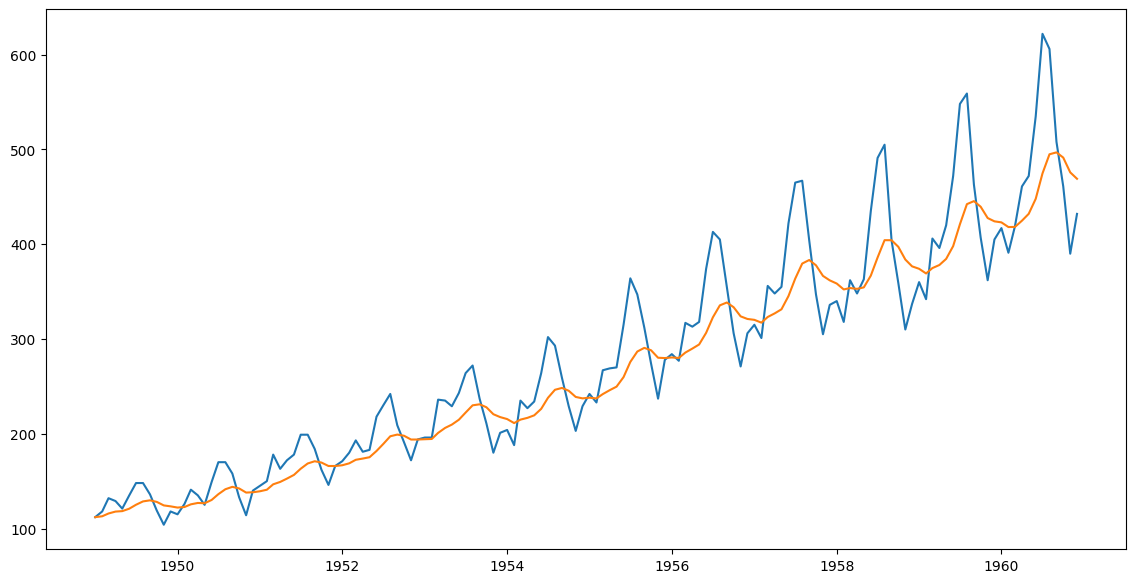

In [71]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# The flight dataset has both a clear trend and seasonality so
# we will use it (See last video for what this is doing in detail)
flight_df = sns.load_dataset('flights')
flight_df['day']='01'
flight_df['month'] = pd.to_datetime(flight_df.month, format='%b').dt.month
flight_df['date'] = pd.to_datetime(flight_df[['year', 'month', 'day']])
flight_df.drop(['year', 'month', 'day'], axis=1, inplace=True)
flight_df.set_index('date', inplace=True)
flight_df = flight_df.dropna() # Clear NaNs

# We must set a frequency to our datetimeindex object
flight_df.index
# Frequencies : B (Business Day), C (Calendar Day), W (Weekly),
# M (Month End), MS (Month Start), Q (Quarter End), QS 
# (Quarter Start), Y (Year End), YS (Year Start), T (Minute)
# S (Second)
flight_df.index.freq = 'MS' # Sets for beginning of the month
flight_df.index

# Simple Smoothing
span = 12
alpha = 2/(span+1)
flt_ewm = flight_df['passengers'].ewm(alpha=alpha,adjust=False).mean()
f_2 = plt.figure(figsize=(12,6), dpi=100)
ax_2 = f_2.add_axes([0.0, 0.0, 0.9, 0.9])
ax_2.plot(flight_df.index, flight_df['passengers'])
ax_2.plot(flight_df.index, flt_ewm)

# SimpleExpSmoothing performs the same as EWM
model = SimpleExpSmoothing(flight_df['passengers'])
fit_model = model.fit(smoothing_level=alpha, optimized=False)
# Shift model up 1
flight_df['ses'] = fit_model.fittedvalues.shift(-1)
flight_df.head(20)

Flight Data with Double Exponential Smoothing:

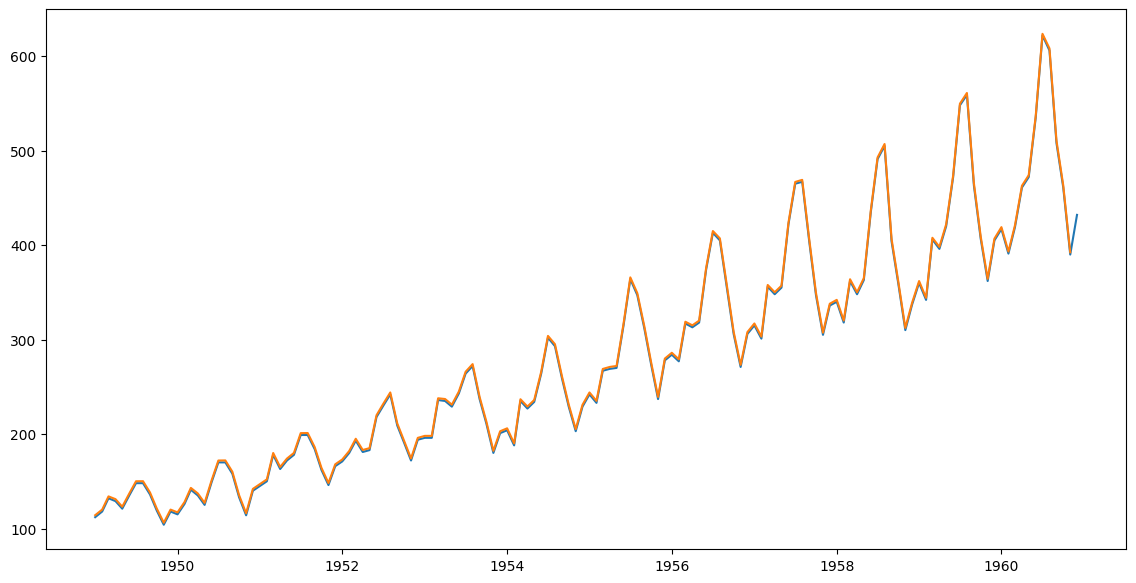

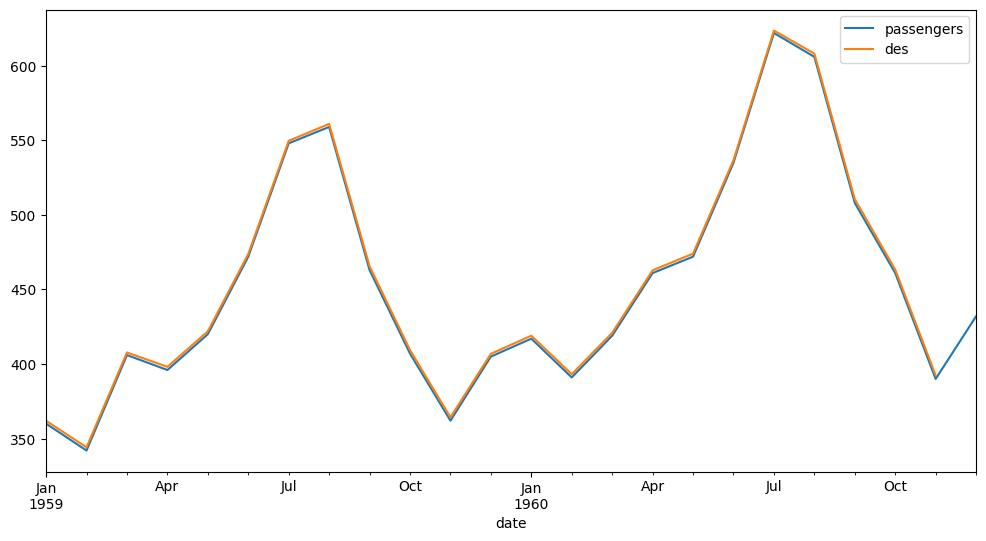

In [77]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# This time we'll act as if the data is linear so we'll use
# the additive method
fit_mod = ExponentialSmoothing(flight_df['passengers'], trend='add').fit()
flight_df['des'] = fit_mod.fittedvalues.shift(-1)
flight_df.head(20)

f_4 = plt.figure(figsize=(12, 6), dpi=100)
ax_4 = f_4.add_axes([0.0, 0.0, 0.9, 0.9])
# You'll see that des falls very close to the real data
ax_4.plot(flight_df.index, flight_df['passengers'])
ax_4.plot(flight_df.index, flight_df['des'])
# ax_4.plot(flight_df.index, flight_df['ses'])

# Let's zoom in on the last 24 months :24 for 1st 12 months
flight_df[['passengers', 'des']].iloc[-24:].plot(figsize=(12, 6))
plt.show()

Seasonality and Holt Winters(Triple Exponential Smoothing):

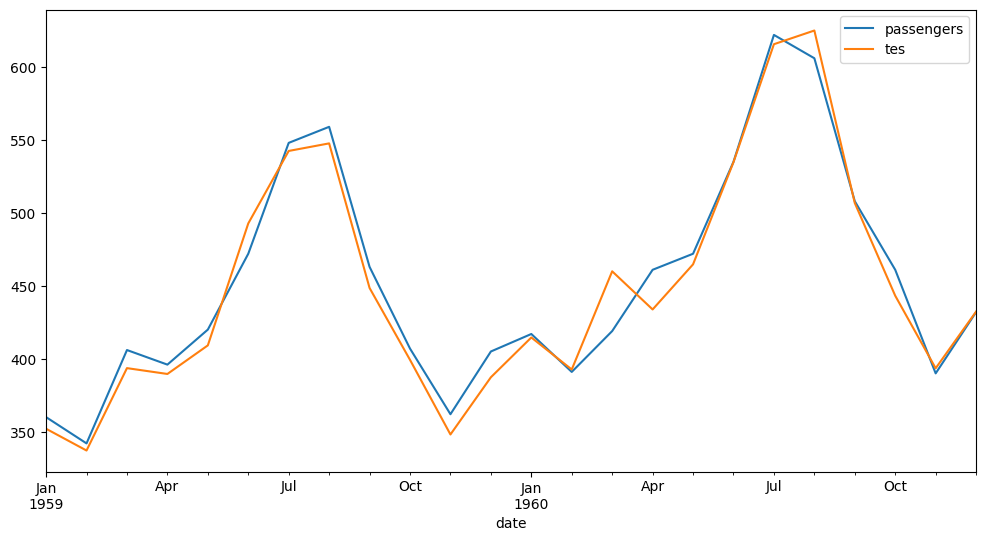

In [79]:
# Now we have to add in seasonality and additive or multiplicatively
# We don't have to shift this time
flight_df['tes'] = ExponentialSmoothing(flight_df['passengers'], trend='add', seasonal='mul', seasonal_periods=12).fit().fittedvalues
# Triple exponential smoothing doesn't look as good because TES focuses on forecasting
# and coming up next I'll cover how you can use all you learned to predict the future
flight_df[['passengers', 'tes']].iloc[-24:].plot(figsize=(12,6))
plt.show()